In [5]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import os
from env import user, host, password
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
import sklearn.preprocessing

#**************************************************Acquire*******************************************************


def get_connection(db, username=user, host=host, password=password):
    '''
    Creates a connection URL
    '''
    return f'mysql+pymysql://{username}:{password}@{host}/{db}'
    
def new_zillow_data():
    '''
    Returns zillow into a dataframe
    '''
    sql_query = ''' SELECT * from properties_2017
    left join airconditioningtype on properties_2017.airconditioningtypeid = airconditioningtype.airconditioningtypeid
    join predictions_2017 using(parcelid)
    where transactiondate between "2017-05-01" and "2017-08-31"
    and propertylandusetypeid in (261)'''
    df = pd.read_sql(sql_query, get_connection('zillow'))
    return df 

def get_zillow_data():
    '''get connection, returns zillow into a dataframe and creates a csv for us'''
    if os.path.isfile('zillow.csv'):
        df = pd.read_csv('zillow.csv', index_col=0)
    else:
        df = new_zillow_data()
        df.to_csv('zillow.csv')
    return df

def clean_zillow(df):
    '''
    this function takes in an unclean zillow df and does the following:
    1.) keeps only columns we need for the project
    2.) drops nulls
    3.) renames columns
    '''
    #select features for df, took these features from my acquire exercise
    features = ['parcelid', 'calculatedfinishedsquarefeet', 'bathroomcnt', 'bedroomcnt','poolcnt','taxvaluedollarcnt','yearbuilt','taxamount','fips']
    df = df[features]

    
    #rename columns for easier use
    df = df.rename(columns={
                            'parcelid': 'parcel_id',
                            'calculatedfinishedsquarefeet': 'sqft',
                            'bathroomcnt': 'bathrooms',
                            'bedroomcnt': 'bedrooms',
                            'poolcnt': 'has_pool',
                            'taxvaluedollarcnt':'tax_value',
                            'yearbuilt':'year_built',
                            'taxamount': 'tax_amount'
        
    })
    
    #set index
    df = df.set_index('parcel_id')
    df['has_pool'] = df.has_pool.fillna(value=0)
    df = df.drop_duplicates()
    df = df.dropna()
    return df
#**************************************************Remove Outliers*******************************************************

def remove_outliers(df):
    '''
    This function takes in a dataframe
    It outputs a the dataframe with the outliers that have a Z score above 3 or below -3 removed
    '''
    df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
    return df

#**************************************************Distributions*******************************************************

def get_hist(df):
    ''' Gets histographs of acquired continuous variables'''
    
    plt.figure(figsize=(16, 3))

    # List of columns
    cols = [col for col in df.columns if col not in ['fips', 'year_built']]

    for i, col in enumerate(cols):

        # i starts at 0, but plot nos should start at 1
        plot_number = i + 1 

        # Create subplot.
        plt.subplot(1, len(cols), plot_number)

        # Title with column name.
        plt.title(col)

        # Display histogram for column.
        df[col].hist(bins=5)

        # Hide gridlines.
        plt.grid(False)

        # turn off scientific notation
        plt.ticklabel_format(useOffset=False)

        plt.tight_layout()

    plt.show()
        
        
def get_box(df):
    ''' Gets boxplots of acquired continuous variables'''
    
    # List of columns
    cols = ['bedrooms', 'bathrooms', 'sqft', 'tax_value', 'tax_amount']

    plt.figure(figsize=(16, 3))

    for i, col in enumerate(cols):

        # i starts at 0, but plot should start at 1
        plot_number = i + 1 

        # Create subplot.
        plt.subplot(1, len(cols), plot_number)

        # Title with column name.
        plt.title(col)

        # Display boxplot for column.
        sns.boxplot(data=df[[col]])

        # Hide gridlines.
        plt.grid(False)

        # sets proper spacing between plots
        plt.tight_layout()

    plt.show()
#**************************************************Prepare*******************************************************

def prepare_zillow():
    '''acquires and prepares the zillow data for us. Drops all 
    outliers'''
    # Get zillow file
    df = get_zillow_data()
    df = clean_zillow(df)
    # Remove the outliers
    df = remove_outliers(df)
    slc =['bedrooms','sqft','tax_value']
    df[slc] = df[slc].astype(int)
    # converting column data thats categorical into objects so that tgey wont be used in mathmetics
    df.fips = df.fips.astype(object)
    df.year_built = df.year_built.astype(object)
    df.has_pool=df.has_pool.astype(object)
    # get distributions of numeric data
    get_hist(df)
    get_box(df)
    # train/validate/test split
    train_validate, test = train_test_split(df, test_size=.2, random_state=123)
    train, validate = train_test_split(train_validate, test_size=.3, random_state=123)
    return train, validate, test 
#**************************************************Wrangle*******************************************************


def wrangle_zillow():
    '''Acquire and prepare data from Zillow database for explore'''
    train, validate, test = prepare_zillow()
    
    return train, validate, test

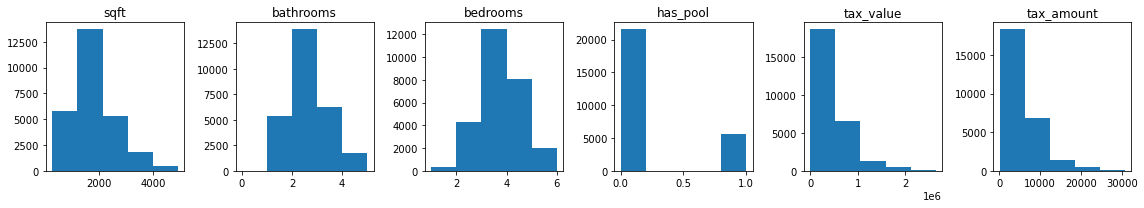

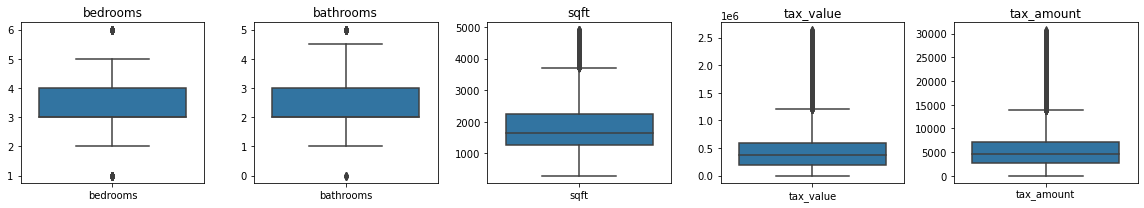

In [6]:
train, validate, test = wrangle_zillow()

In [8]:
len(train)+len(validate)+len(test)

27124

In [ ]:
train.info()

In [ ]:
df

In [ ]:
df.duplicated().value_counts()

In [ ]:
remove_outliers(df, k, col_list)


In [ ]:
def prepare_zillow():
    '''acquires and prepares the zillow data for us. Drops all 
    outliers'''
    # Get zillow file
    df = get_zillow_data()
    df = clean_zillow(df)
    return df

In [ ]:
prepare_zillow()

In [ ]:
def prepare_zillow():
    '''acquires and prepares the zillow data for us. Drops all 
    outliers'''
    # Get zillow file
    df = get_zillow_data()
    df = clean_zillow(df)
    # Remove the outliers
    return df

In [ ]:
df = prepare_zillow()

In [ ]:
df

In [ ]:
def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df1 = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df1

In [ ]:
remove_outliers(df,k=1.5 , col_list=df.columns)

In [ ]:
df